In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-of-tweets/test_samples.txt
/kaggle/input/sentiment-analysis-of-tweets/train.txt


In [ ]:
#importing all the libraries

import sys , os , re , csv , codecs , numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation,BatchNormalization
from keras.layers import Bidirectional,GlobalMaxPool1D,GlobalAvgPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints , optimizers, layers
from keras.utils import to_categorical


In [ ]:
#getting the train data
train = pd.read_csv('/kaggle/input/sentiment-analysis-of-tweets/train.txt')
#loading the test data
test = pd.read_csv('/kaggle/input/sentiment-analysis-of-tweets/test_samples.txt')
#diplay first 5 rows of train
train.head()
#one hot encoding the labels
df = pd.concat([train,pd.get_dummies(train['sentiment'])],axis=1)
#df.head()
train_data = df['tweet_text']
#train_data.head()

In [ ]:
test_data = test['tweet_text']
test_data.head()

0    @jjuueellzz down in the Atlantic city, ventnor...
1    Musical awareness: Great Big Beautiful Tomorro...
2    On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3    Kapan sih lo ngebuktiin,jan ngomong doang Susa...
4    Excuse the connectivity of this live stream, f...
Name: tweet_text, dtype: object

In [ ]:
#creating the array of labels in serial with their respective texts
classes = ['neutral' , 'negative' , 'positive']
y = df[classes].values
y

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [ ]:
#checking for null values in train and test data
train.isnull().any()
test.isnull().any()

tweet_id      False
tweet_text    False
dtype: bool

In [ ]:
#configuration  parameters
LATENT_DIM_DECODER = 400
BATCH_SIZE =128
EPOCHS = 20
LATENT_DIM = 400
NUM_SAMPLES = 10000
MAX_SEQUENCE_LEN = 1000
MAX_NUM_WORDS = 100000
EMBEDDING_DIM = 300


In [ ]:
#NLTK python library for preprocessing
import nltk
#nltk.download('wordnet')
#for tokenization
from nltk.tokenize import RegexpTokenizer
#for stemming
from nltk.stem import WordNetLemmatizer,PorterStemmer
#for removing stopwords
from nltk.corpus import stopwords
#importing regex library of python
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
#function for performing all preproccing steps at once
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens]#  if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

#make a dataframe of preprocessed text
df['cleanText']=train_data.map(lambda s:preprocess(s)) 

In [ ]:
test['clean_text']=test['tweet_text'].map(lambda s:preprocess(s))
test_final = test['clean_text']
test_final

0       jjuueellzz down in the atlantic city ventnor m...
1       musical awareness great big beautiful tomorrow...
2       on radio fm fri oct labour analyst shawn hatti...
3       kapan sih lo ngebuktiin jan ngomong doang susa...
4       excuse the connectivity of this live stream fr...
                              ...                        
5393    it s a wednesday girls night out as s band wil...
5394    night college course sorted just have to enrol...
5395    for the st time in years for your splendiferou...
5396    nurses day may nursing the heart beat of the h...
5397    we have minutes left until the nd episode of s...
Name: clean_text, Length: 5398, dtype: object

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
#breaking the sentence into unique words/tokens
#expecting max tokens to be 20k
train_final = df['cleanText']
max_feat=40000
#tokenize sentence into list of words
tokenizer = Tokenizer(num_words=max_feat)#setting up tokenizer
#fiiting the tokenizer on out data
tokenizer.fit_on_texts(list(train_final))


In [ ]:
train_final

0        gas by my house hit i um going to chapel hill ...
1        theo walcott is still shit uc watch rafa and j...
2        its not that i um a gsp fan uc i just hate nic...
3        iranian general says israel us iron dome can u...
4        tehran uc mon amour obama tried to establish t...
                               ...                        
21460    the day after newark ill be able to say i met ...
21461    fec hold farewell session for seven ministers ...
21462    luca di montezemolo who s last day was monday ...
21463    coffee is pretty much the answer to all questi...
21464    niki lauda just confirmed to sky that alonso w...
Name: cleanText, Length: 21465, dtype: object

In [ ]:
tokenizer2 = Tokenizer(num_words=max_feat)#setting up tokenizer
#fiiting the tokenizer on out data
tokenizer2.fit_on_texts(list(test_final))

In [ ]:
#converting text into sequence of numbers to feed in neural network
sequence_train = tokenizer.texts_to_sequences(train_final)
sequence_test = tokenizer2.texts_to_sequences(test_final)
# get the word to index mapping for input language
word2idx_inputs = tokenizer.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))


Found 34302 unique input tokens.


In [ ]:
#LOADING PRETRAINED WORD VECTORS
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('/kaggle/glove.6B.300d.txt', encoding="utf8") as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


In [ ]:
#EMBEDDING MATRIX
# prepare embedding matrix of words for embedding layer
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if(i < MAX_NUM_WORDS):
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
max_len = [len(s) for s in sequence_train]
print(max(max_len))

1074


In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
#scaling all the sequences to a fixed length
#dimension of input to the layer should be constant
#scaling each comment sequence to a fixed length to 200
#comments smaller than 200 will be padded with zeros to make their length as 200
max_len=1000
#pad the train and text sequence to be of fixed length (in keras input in lstm should be of fixed length sequnece)
x_train=pad_sequences(sequence_train,maxlen=max_len)
x_test=pad_sequences(sequence_test,maxlen=max_len)

In [ ]:
from keras.layers import Embedding

In [ ]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=True
)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

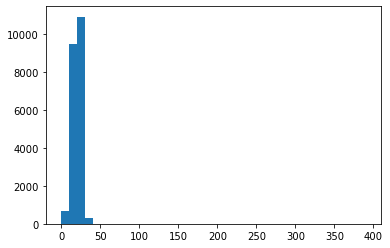

In [ ]:
len_words = [len(words) for words in sequence_train]
#distribution of sequence
plt.hist(len_words, bins = np.arange(0,400,10))
plt.show()
# we can see that most of the comments have [0,50]  words

In [ ]:
from keras.layers import Input

In [ ]:
input = Input(shape=(max_len,))

In [ ]:
#feeding the output of previous layer to the embedding layer that converts 
#the sequences into vector representation to detect relevance and context 
#of a particular word
embed_layer =embedding_layer(input)

In [ ]:
import tensorflow as tf

In [ ]:
from keras.layers.recurrent import LSTM

In [ ]:
#passing the previous output as input to the BI_LSTM layer
LSTM_layer = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, name='BI_lstm_layer'))(embed_layer)
sec_LSTM_layer = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, name='BI2_lstm_layer'))(LSTM_layer)
batchnorm = BatchNormalization()(sec_LSTM_layer)

In [ ]:
#dimension reduction using pooling layer
red_dim_layer = tf.keras.layers.GlobalAvgPool1D()(batchnorm)

In [ ]:
##### adding dropout layer for better generalization
#setting value as 0.1 , which means 10$ of nodes will be randomly disabled
drop_layer = Dropout(0.55)(red_dim_layer)

In [ ]:
#densely connected layer
dense1 = Dense(128,activation='elu')(drop_layer)
batchnorm2 = BatchNormalization()(dense1)
dense2 = Dense(128,activation='elu')(batchnorm2)
batchnorm3 = BatchNormalization()(dense2)
dense3 = Dense(128,activation='elu')(batchnorm3)

In [ ]:
#adding another dropout layer
drop_layer2 = Dropout(0.55)(dense3)

In [ ]:
#adding the output dense layer with sigmoid activation to get result 
#3  classes as output
output_dense = Dense(3,activation='softmax')(drop_layer2)

In [ ]:
#connecting the inputs and outputs to create a model and compiling the model
from keras.optimizers import Adagrad,Adam,RMSprop
model = Model(inputs=input , outputs = output_dense)
model.compile(loss = 'categorical_crossentropy',
             optimizer = RMSprop(lr=0.001),
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 300)         10290900  
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 512)         1574912   
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 512)         2048      
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [ ]:
#Fitting the model 
batch_size=64
epochs = 30
model.fit(x_train,y,batch_size=batch_size,epochs = epochs,validation_split=0.2)

Epoch 1/30
269/269 [==============================] - 164s 609ms/step - loss: 1.0977 - accuracy: 0.4971 - val_loss: 1.9855 - val_accuracy: 0.3988
Epoch 2/30
269/269 [==============================] - 162s 602ms/step - loss: 0.7904 - accuracy: 0.6585 - val_loss: 8.8136 - val_accuracy: 0.4281
Epoch 3/30
269/269 [==============================] - 162s 601ms/step - loss: 0.6312 - accuracy: 0.7466 - val_loss: 28.4012 - val_accuracy: 0.3988
Epoch 4/30
269/269 [==============================] - 162s 602ms/step - loss: 0.5122 - accuracy: 0.8026 - val_loss: 32.2878 - val_accuracy: 0.4281
Epoch 5/30
269/269 [==============================] - 162s 603ms/step - loss: 0.4010 - accuracy: 0.8530 - val_loss: 22.5790 - val_accuracy: 0.3990
Epoch 6/30
269/269 [==============================] - 162s 602ms/step - loss: 0.3176 - accuracy: 0.8894 - val_loss: 36.6653 - val_accuracy: 0.1731
Epoch 7/30
269/269 [==============================] - 162s 602ms/step - loss: 0.2551 - accuracy: 0.9094 - val_loss: 16.2